# Catboost Modelling

In this notebook, a final sales forecasting model based on the CatBoost algorithm is created. More information can be found here: https://catboost.ai/

Just as the Random Forest model, the final model is also a tree-based model. These types of algorithms lend themselves well to predicting target features that are not normally distributed, as is the case with sales here. Moreover, CatBoost is specifically tailored to datasets with many categorical variables. With the expception of weather and lag variables, this dataset mainly contains categorical features, including dummy variables.

Given the flexibility of CatBoost, no additional preprocessing is necessary. It can handle object (categorical) variables, missing values and responds well to non-normally distributed target variables.

In [1]:
pip install catboost sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.1/134.1 kB 9.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.patches import Patch
import seaborn as sns
import datetime as dt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error

from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from statsmodels.tsa.stattools import adfuller

from catboost import CatBoostRegressor
import catboost as cb
#import optuna

In [4]:
# for google colab
!unrar x drive/MyDrive/sweet-spot-donut-sales-forecasting.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from drive/MyDrive/sweet-spot-donut-sales-forecasting.rar

Extracting  functions_model.py                                             0%  OK 
Extracting  functions_vis.py                                               0%  OK 
Extracting  train_df.csv                                                  99%  OK 
Extracting  test_df.csv                                                  100%  OK 
All OK


In [5]:
%run functions_model.py
%run functions_vis.py

In [6]:
pd.set_option("display.max_columns", None)

### Loading the dataset

In [7]:
d = pd.read_csv("train_df.csv")
d_test = pd.read_csv("test_df.csv")

In [8]:
d['date'] = pd.to_datetime(d['date'])
d_test['date'] = pd.to_datetime(d_test['date'])

### Creating validation dataset

A validation set, containing the last 7 days of the entire training dataset, is created. The validation set is used for evaluation purposes and early stopping in the CatBoost model.

In [9]:
train, val = create_val_set(d)

## Modelling

#### Selecting features

In order for the CatBoost algorithm to recognize categorical features, all variables are saved either as categorical or numerical. The date variable will serve as the index, while the lag features will only be used in the training and validation, but not the test dataset.

In [10]:
date = ["date"]

catfeat = ["store_name","item_category","hol_pub","hol_school","weekday","day","month","year","week_year","nye","valentines_day","halloween", "street_market","public_space","box_deal"]

numfeat = ["days_back","temperature_2m_mean","sunshine_duration","precipitation_hours"]

lag = ["lag1","lag2", "lag7"]

Two types of sets were created:

1. The first type of train, validation and test datasets contains all features at the day, store and product level.
2. The second type contains all features only at the day and store level. The different product categories were removed and **only total daily sales** per store are kept.

In [12]:
x_train = train[date + catfeat + numfeat + lag]
x_train = x_train.set_index("date")
x_train_daily = x_train[(x_train["item_category"] == "daily total")].drop("item_category", axis = 1)
y_train = train['total_amount']
y_train_daily = train[(train["item_category"] == "daily total")]['total_amount']

x_val = val[date + catfeat + numfeat + lag]
x_val = x_val.set_index("date")
x_val_daily = x_val[(x_val["item_category"] == "daily total")].drop("item_category", axis = 1)
y_val = val['total_amount']
y_val_daily = val[(val["item_category"] == "daily total") ]['total_amount']

x_test = d_test[date + catfeat + numfeat]
x_test = x_test.set_index("date")
x_test_daily = x_test[(x_test["item_category"] == "daily total")].drop("item_category", axis = 1)
y_test = d_test['total_amount']
y_test_daily = d_test[(d_test["item_category"] == "daily total")]['total_amount']

In [ ]:
#catfeat.remove("item_category")

#### Converting holiday features to integer

In [13]:
x_train["hol_pub"] = x_train["hol_pub"].apply(np.int64)
x_train["hol_school"] = x_train["hol_school"].apply(np.int64)
x_train_daily["hol_pub"] = x_train_daily["hol_pub"].apply(np.int64)
x_train_daily["hol_school"] = x_train_daily["hol_school"].apply(np.int64)

x_val["hol_pub"] = x_val["hol_pub"].apply(np.int64)
x_val["hol_school"] = x_val["hol_school"].apply(np.int64)
x_val_daily["hol_pub"] = x_val_daily["hol_pub"].apply(np.int64)
x_val_daily["hol_school"] = x_val_daily["hol_school"].apply(np.int64)

x_test["hol_pub"] = x_test["hol_pub"].apply(np.int64)
x_test["hol_school"] = x_test["hol_school"].apply(np.int64)
x_test_daily["hol_pub"] = x_test_daily["hol_pub"].apply(np.int64)
x_test_daily["hol_school"] = x_test_daily["hol_school"].apply(np.int64)

The train and target variables are concatenated to obtain a train and test set at the daily sales level, without the individual product categories.

In [14]:
train_daily = pd.concat([x_train_daily.reset_index(), y_train_daily.reset_index(drop= True)], axis = 1)

test_daily = pd.concat([x_test_daily.reset_index(), y_test_daily.reset_index(drop= True)], axis = 1)

### Custom CV split

In [15]:
def create_train_validation_folds(df):
    last_val_date = df.date.max()
    cv = []
    for n in range(5):
        first_val_date = last_val_date - dt.timedelta(days=6)
        train_index = df[df.date<first_val_date].index
        val_index = df[(df.date>=first_val_date) & (df.date<=last_val_date)].index
        cv.append((train_index,val_index))
        last_val_date = first_val_date - dt.timedelta(days=1)
    cv = cv[::-1]
    return cv

In [ ]:
create_train_validation_folds(train_daily)

In [ ]:
def create_train_validation_dataset(df):
    last_val_date = df.date.max()
    cv = []
    for n in range(5):
        first_val_date = last_val_date - dt.timedelta(days=6)
        train_fold = df[df.date<first_val_date]
        val_fold = df[(df.date>=first_val_date) & (df.date<=last_val_date)]
        cv.append((train_fold,val_fold))
        last_val_date = first_val_date - dt.timedelta(days=1)
    cv = cv[::-1]
    return cv

In [ ]:
for i in range(5):
  globals()[f"train_{i}"], globals()[f"val_{i}"] = create_train_validation_dataset(train_daily)[i]

### Hyperparameter Tuning


Training tree-based algorithm often leads to overfitting. In order to create a generalizable model, it is necessary to "prune" the trees by putting constraints on how well they can learn from the data. The following hyperparameters are tuned in the step below:

* Number of trees
* Learning rate
* L2 leaf regularization
* Tree depth (number of levels)
* Proportion of the sample used for each tree
* Proportion of the features used for each tree
* A minimum amount of datapoints in a leaf before a split can occur
* Minimum child weight


In [11]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sktime.split import ExpandingWindowSplitter
from sktime.utils import plot_windows
from sktime.utils._testing.hierarchical import _make_hierarchical
from sktime.transformations.series.summarize import WindowSummarizer

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [12]:
fh = np.arange(7) + 1

In [24]:
train_2 = train[date + catfeat + numfeat]
train_2 = train_2[train_2["item_category"] != "daily total"]
train_2 = pd.concat([train_2, train[train["item_category"] != "daily total"]["total_amount"]], axis = 1)



In [25]:
agg_columns = train_2.columns.difference(['date', 'store_name', 'item_category'] + ["total_amount"])
agg_dict = {col: "first" for col in agg_columns}
agg_dict["total_amount"] = "sum"

train_2 = train_2.groupby(['date', 'store_name', 'item_category']).agg(agg_dict).reset_index().sort_values(by = "date", ascending = False).reset_index(drop = True)
train_2 = train_2.set_index(["store_name","item_category","date"]).sort_index()


#train_2_wind = transformer.fit_transform(train_2)
#train_2_wind = pd.concat([train_2["total_amount"], train_2], axis = 1)
#train_2_wind = train_2_wind.dropna()

#x_train_2_wind = train_2_wind.iloc[:,8:]
#y_train_2_wind = train_2_wind.iloc[:,:8]

**Cross-validation**

In [44]:
catfeat = ["hol_pub","hol_school","weekday","day","month","year","week_year","nye","valentines_day","halloween", "street_market","public_space","box_deal"]

In [80]:
def prepro_data (train):

  groups = []
  train_2_upd = []
  train_2_wind_upd = []
  all_dates_list = []

  for (store, item_category), group in train.groupby(level=['store_name', 'item_category']):
    groups.append(((store, item_category),group))

  for i in range(len(groups)):
    train_2_upd.append(groups[i][1].reset_index().set_index("date"))

  for i in range(len(train_2_upd)):
    all_dates = pd.date_range(start=train_2_upd[i].index.min(),
                            end=train_2_upd[i].index.max(), freq='D')
    all_dates_list.append(all_dates)

  for i in range(len(train_2_upd)):
    train_2_upd.append(train_2_upd[i].reindex(all_dates_list[i]))


  for i in range(len(train_2_upd)):
    train_2_upd[i].index.name = "date"

  train_2_upd = train_2_upd[37:]

  for i in range(len(train_2_upd)):
    train_2_upd[i]["store_name"] = train_2_upd[i]["store_name"].ffill()
    train_2_upd[i]["item_category"] = train_2_upd[i]["item_category"].ffill()
    train_2_upd[i] = train_2_upd[i].interpolate()

  for i in range(len(train_2_upd)):
    train_2_upd.append(train_2_upd[i].reset_index().set_index(["store_name","item_category","date"]))

  train_2_upd = train_2_upd[37:]


  train_2_wind_upd = train_2_upd.copy()

  kwargs = {"lag_feature": {
      "lag":[1,2,3],
      "mean": [[1,7], [1, 15], [1,30]],
      "std": [[1,4]]
      },
      "target_cols":["total_amount"]}

  transformer = WindowSummarizer(**kwargs)

  for i in range(len(train_2_wind_upd)):
    train_2_wind_upd[i] = transformer.fit_transform(train_2_wind_upd[i])
    train_2_wind_upd[i] = pd.concat([train_2_upd[i]["total_amount"], train_2_wind_upd[i]], axis = 1)
    train_2_wind_upd[i] = train_2_wind_upd[i].dropna()

  for i in range(len(train_2_wind_upd)):
    train_2_wind_upd[i][catfeat] = train_2_wind_upd[i][catfeat].astype(int)
    train_2_wind_upd[i][catfeat] = train_2_wind_upd[i][catfeat].astype("category")

  for i in range(len(train_2_wind_upd)):
    train_2_wind_upd[i] = (groups[i][0], train_2_wind_upd[i])

  return train_2_wind_upd



In [81]:
train_2_wind_upd = prepro_data(train_2)

<ipython-input-80-0ec2fb9a114d>:31: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  train_2_upd[i] = train_2_upd[i].interpolate()
<ipython-input-80-0ec2fb9a114d>:31: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  train_2_upd[i] = train_2_upd[i].interpolate()
<ipython-input-80-0ec2fb9a114d>:31: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  train_2_upd[i] = train_2_upd[i].interpolate()
<ipython-input-80-0ec2fb9a114d>:31: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  train_2_upd[i] = train_2_upd[i

In [82]:
train_2_wind_upd[1][1].iloc[(train_2_wind_upd[1][1].index.get_level_values("date") == "2022-11-05") |
                          (train_2_wind_upd[1][1].index.get_level_values("date") == "2022-11-06") |
                         (train_2_wind_upd[1][1].index.get_level_values("date") == "2022-11-07") |
                         (train_2_wind_upd[1][1].index.get_level_values("date") == "2022-11-08") ]

total_amount  total_amount_lag_1  \
store_name item_category date                                           
Altona     mixed         2022-11-05         550.0               296.0   
                         2022-11-06         379.0               550.0   
                         2022-11-07         208.0               379.0   
                         2022-11-08         146.0               208.0   

                                     total_amount_lag_2  total_amount_lag_3  \
store_name item_category date                                                 
Altona     mixed         2022-11-05               216.0               212.0   
                         2022-11-06               296.0               216.0   
                         2022-11-07               550.0               296.0   
                         2022-11-08               379.0               550.0   

                                     total_amount_mean_1_7  \
store_name item_category date                                
Altona     mixed         2022-11-05             403.714286   
                         2022-11-06             383.428571   
                         2022-11-07             367.285714   
                         2022-11-08             303.000000   

                                     total_amount_mean_1_15  \
store_name item_category date                                 
Altona     mixed         2022-11-05              378.933333   
                         2022-11-06              385.600000   
                         2022-11-07              362.466667   
                         2022-11-08              341.800000   

                                     total_amount_mean_1_30  \
store_name item_category date                                 
Altona     mixed         2022-11-05              391.333333   
                         2022-11-06              394.866667   
                         2022-11-07              397.433333   
                         2022-11-08              381.300000   

                                     total_amount_std_1_4 box_deal day  \
store_name item_category date                                            
Altona     mixed         2022-11-05             39.799497        1   5   
                         2022-11-06            159.108977        1   6   
                         2022-11-07            142.936758        1   7   
                         2022-11-08            145.657990        1   8   

                                     days_back halloween hol_pub hol_school  \
store_name item_category date                                                 
Altona     mixed         2022-11-05      566.0         0       0          0   
                         2022-11-06      565.0         0       0          0   
                         2022-11-07      564.0         0       0          0   
                         2022-11-08      563.0         0       0          0   

                                    month nye  precipitation_hours  \
store_name item_category date                                        
Altona     mixed         2022-11-05    11   0                  1.0   
                         2022-11-06    11   0                  2.5   
                         2022-11-07    11   0                  4.0   
                         2022-11-08    11   0                  1.0   

                                    public_space street_market  \
store_name item_category date                                    
Altona     mixed         2022-11-05            1             0   
                         2022-11-06            1             0   
                         2022-11-07            1             0   
                         2022-11-08            1             0   

                                     sunshine_duration  temperature_2m_mean  \
store_name item_category date                                                 
Altona     mixed         2022-11-05           7.907053                 8.00   
                 

In [84]:
def get_initial_window_size(store_group, validation_length, num_folds):
    total_periods = len(store_group.index.get_level_values('date').unique())
    initial_window = total_periods - validation_length * num_folds
    return initial_window

cv_list = []

for (store,item), group in train_2_wind_upd:

    # Calculate the initial window size for the current store
    initial_window = get_initial_window_size(group, validation_length = 7, num_folds = 5)

    # Initialize the ExpandingWindowSplitter for the current group
    splitter = ExpandingWindowSplitter(
        initial_window=initial_window,
        step_length=7,
        fh=list(range(1, 7 + 1))
    )

    cv_list.append(({f"{store}"+"_"+f"{item}":splitter},
                        {f"{store}"+"_"+f"{item}":group}))


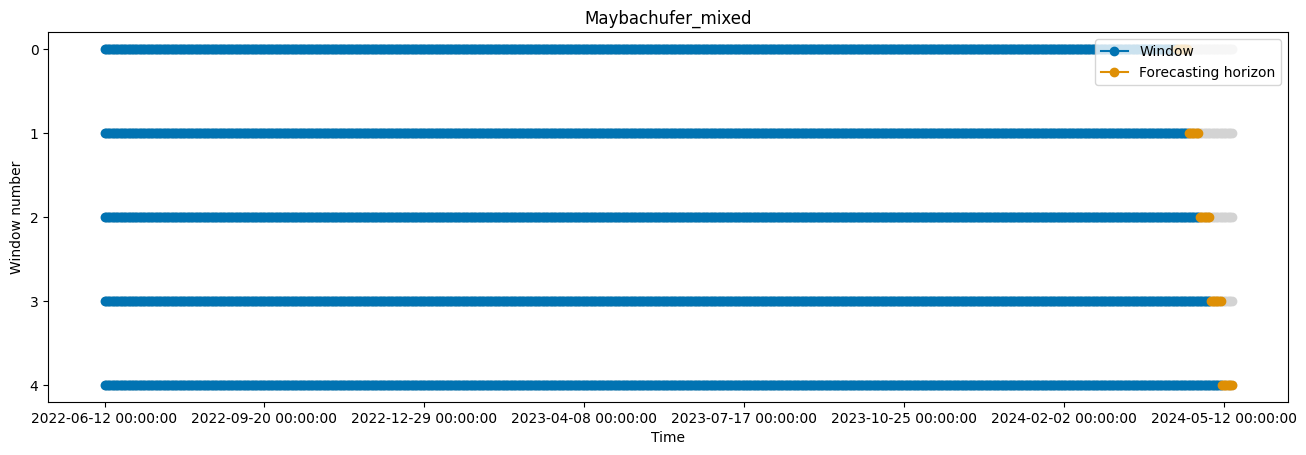

In [63]:
for i in range(15,16):
    plot_windows(list(cv_list[i][0].values())[0], list(cv_list[i][1].values())[0].reset_index().set_index("date")["total_amount"],
                 title = list(cv_list[i][0].keys())[0])

In [97]:
model = cb.CatBoostRegressor()
forecaster = make_reduction(estimator = model, strategy="recursive", window_length = 7)

In [98]:
params = {
    'estimator__n_estimators': np.arange(250,1000,1),
    "estimator__learning_rate": np.logspace(-4, -1),
    "estimator__l2_leaf_reg": np.linspace(2, 30),
    "estimator__depth":np.arange(3,17,1),
    #"estimator__subsample": np.linspace(0.05, 1.0),
    "estimator__colsample_bylevel": np.linspace(0.05, 1.0),
    "estimator__min_data_in_leaf": np.arange(10, 51, 1)}

In [99]:
rscv_list = []

for i in range(len(cv_list)):
    rscv = ForecastingRandomizedSearchCV(forecaster = forecaster,
                                         cv = list(cv_list[i][0].values())[0],
                                         param_distributions=params,
                                         strategy="refit", n_iter=10, error_score="raise")


    rscv_list.append({f"rscv_{list(cv_list[i][1].keys())[0]}":rscv})

In [101]:
fit_cv_list = []

for m in range(len(rscv_list)):

    fitted_cv = list(rscv_list[m].values())[0].fit(y = list(cv_list[0][1].values())[0][["total_amount"]],
                                                   X = list(cv_list[m][1].values())[0].iloc[:,1:])

    fit_cv_list.append({f"rscv_{list(rscv_list[m].keys())[0]}":fitted_cv})

0:	learn: 45.4850081	total: 62.3ms	remaining: 21.4s
1:	learn: 44.5307231	total: 76.3ms	remaining: 13s
2:	learn: 43.8752186	total: 97.9ms	remaining: 11.1s
3:	learn: 42.9332787	total: 112ms	remaining: 9.51s
4:	learn: 42.1115162	total: 132ms	remaining: 8.94s
5:	learn: 41.4017177	total: 145ms	remaining: 8.19s
6:	learn: 40.7905912	total: 170ms	remaining: 8.19s
7:	learn: 40.1503014	total: 188ms	remaining: 7.9s
8:	learn: 39.6146338	total: 201ms	remaining: 7.49s
9:	learn: 38.8991021	total: 221ms	remaining: 7.4s
10:	learn: 38.3089815	total: 236ms	remaining: 7.14s
11:	learn: 37.7696426	total: 256ms	remaining: 7.08s
12:	learn: 37.3366629	total: 272ms	remaining: 6.93s
13:	learn: 36.9084707	total: 296ms	remaining: 6.97s
14:	learn: 36.7821934	total: 309ms	remaining: 6.79s
15:	learn: 36.3400140	total: 333ms	remaining: 6.83s
16:	learn: 35.9125543	total: 346ms	remaining: 6.66s
17:	learn: 35.5020229	total: 369ms	remaining: 6.69s
18:	learn: 35.0843804	total: 384ms	remaining: 6.56s
19:	learn: 34.9762454	t

KeyError: "None of [MultiIndex([('Altona', 'classics', '2022-10-30'),\n            ('Altona', 'classics', '2022-10-31'),\n            ('Altona', 'classics', '2022-11-01'),\n            ('Altona', 'classics', '2022-11-02'),\n            ('Altona', 'classics', '2022-11-03'),\n            ('Altona', 'classics', '2022-11-04'),\n            ('Altona', 'classics', '2022-11-05'),\n            ('Altona', 'classics', '2022-11-06'),\n            ('Altona', 'classics', '2022-11-07'),\n            ('Altona', 'classics', '2022-11-08'),\n            ...\n            ('Altona', 'classics', '2024-04-03'),\n            ('Altona', 'classics', '2024-04-04'),\n            ('Altona', 'classics', '2024-04-05'),\n            ('Altona', 'classics', '2024-04-06'),\n            ('Altona', 'classics', '2024-04-07'),\n            ('Altona', 'classics', '2024-04-08'),\n            ('Altona', 'classics', '2024-04-09'),\n            ('Altona', 'classics', '2024-04-10'),\n            ('Altona', 'classics', '2024-04-11'),\n            ('Altona', 'classics', '2024-04-12')],\n           names=['store_name', 'item_category', 'date'], length=531)] are in the [index]"

In [ ]:
model = cb.CatBoostRegressor(cat_features=catfeat)

In [ ]:
randomized_search_result = model.randomized_search(params,
                                                  # n_iter=30,
                                                   X= x_train_daily,
                                                   y= y_train_daily,
                                                   cv = create_train_validation_folds(train_daily),
                                                   plot=True,
                                                   verbose = 500,
                                                   calc_cv_statistics=True)

In [ ]:
pd.DataFrame(randomized_search_result.get("cv_results"))

In [ ]:
randomized_search_result.get("params")

In [ ]:
#def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2, 30),
        "depth": trial.suggest_int("depth", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "min_child_weight": trial.suggest_int(1, 300)
    }

    model = CatBoostRegressor(**params, silent=True, allow_writing_files = False, cat_features = catfeat)

    model_cv = optuna.integration.OptunaSearchCV(estimator = model, param_distributions = params, cv = create_train_validation_folds(train_daily), n_jobs = -1, n_trials = 30)

    #model.fit(x_train_daily, y_train_daily, eval_set = (create_train_validation_folds_cat(x_train_daily_totalamount)), cat_features = catfeat, verbose = 1000, plot = False)

    # y_val_pred_daily = model_cv.predict(x_val_daily)

    #rmse = mean_squared_error(y_val_daily, y_val_pred_daily, squared=False)

    #return rmse

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=30)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

In [ ]:
# Best model

model = CatBoostRegressor(n_estimators = 2620, learning_rate = 0.0487,
 depth = 5, subsample = 0.21, colsample_bylevel = 0.2, min_data_in_leaf = 21, early_stopping_rounds = 69, cat_features = catfeat, random_state = 123, allow_writing_files = True)

model.fit(x_train_daily, y_train_daily, eval_set=(x_val_daily, y_val_daily), verbose = 500, plot = True)

### Feature importances

In [ ]:
model.get_feature_importance(prettified=True).plot(x = "Feature Id", y = "Importances", kind = "bar")

### Evaluation metrics train and validation set

In [ ]:
y_train_pred = model.predict(x_train_daily)
print(f"R-squared train: {round(r2_score(y_train_daily, y_train_pred),6)}")
print(f"MAPE train: {round(100*mean_absolute_percentage_error(y_train_daily, y_train_pred),2)}\n")

y_val_pred = model.predict(x_val_daily)
print(f"R-squared validation: {round(r2_score(y_val_daily, y_val_pred),6)}")
print(f"MAPE validation: {round(100*mean_absolute_percentage_error(y_val_daily, y_val_pred),2)}")

# Test dataset

In [ ]:
x_test_daily_totalamount, y_test_pred =  pred_test(train = x_train_daily_totalamount, test = x_test_daily_totalamount, model = model, numfeat = numfeat, catfeat = catfeat)

### Residuals by store

In [ ]:
difference_df = diff_overview(data = x_test_daily_totalamount, pred = y_test_pred, stores = all)

### Residual Plot Analysis

In [ ]:
sns.scatterplot(data = difference_df, x = "Predicted", y = "Stand_resid")

plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Sales (Daily total)")
plt.ylabel("Standardized Residuals")

plt.show()

### Evaluation metrics train and test set

In [ ]:
fit_overview(ytrain = y_train_daily, ytrainpred = y_train_pred, ytest = y_test_daily, ytestpred = y_test_pred)

In [ ]:
mape_stores(x_test_daily_totalamount, y_test_pred)

### Visualisation of predictions

In [ ]:
df_predicted = pd.concat(
    [
    difference_df[["Date","Store name","Observed","Predicted"]].rename(columns = {"Date":"date","Store name":"store_name","Observed":"total_amount"}),
    d[(d["date"] >= pd.to_datetime("2024-05-01")) & (d["item_category"] == "daily total")][["date","store_name","total_amount"]]
    ]
    )

In [ ]:
ts_predicted(df_predicted)